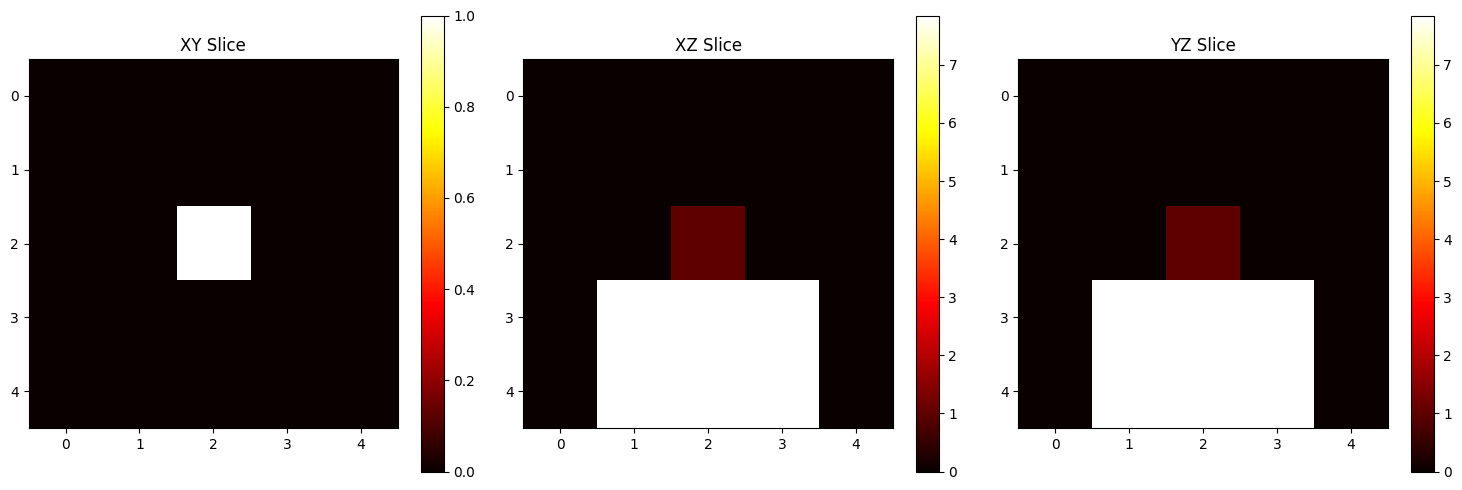

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Load your voxel data
voxels = np.load('/home/jiajun/muography/detectors/planar/soil_target_voxels.npy')

# Quick plot
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(voxels[:, :, voxels.shape[2]//2].T, cmap='hot')
plt.title('XY Slice')
plt.colorbar()

plt.subplot(132)
plt.imshow(voxels[:, voxels.shape[1]//2, :].T, cmap='hot')
plt.title('XZ Slice')
plt.colorbar()

plt.subplot(133)
plt.imshow(voxels[voxels.shape[0]//2, :, :].T, cmap='hot')
plt.title('YZ Slice')
plt.colorbar()

plt.tight_layout()
plt.show()

Plotting 18 voxels


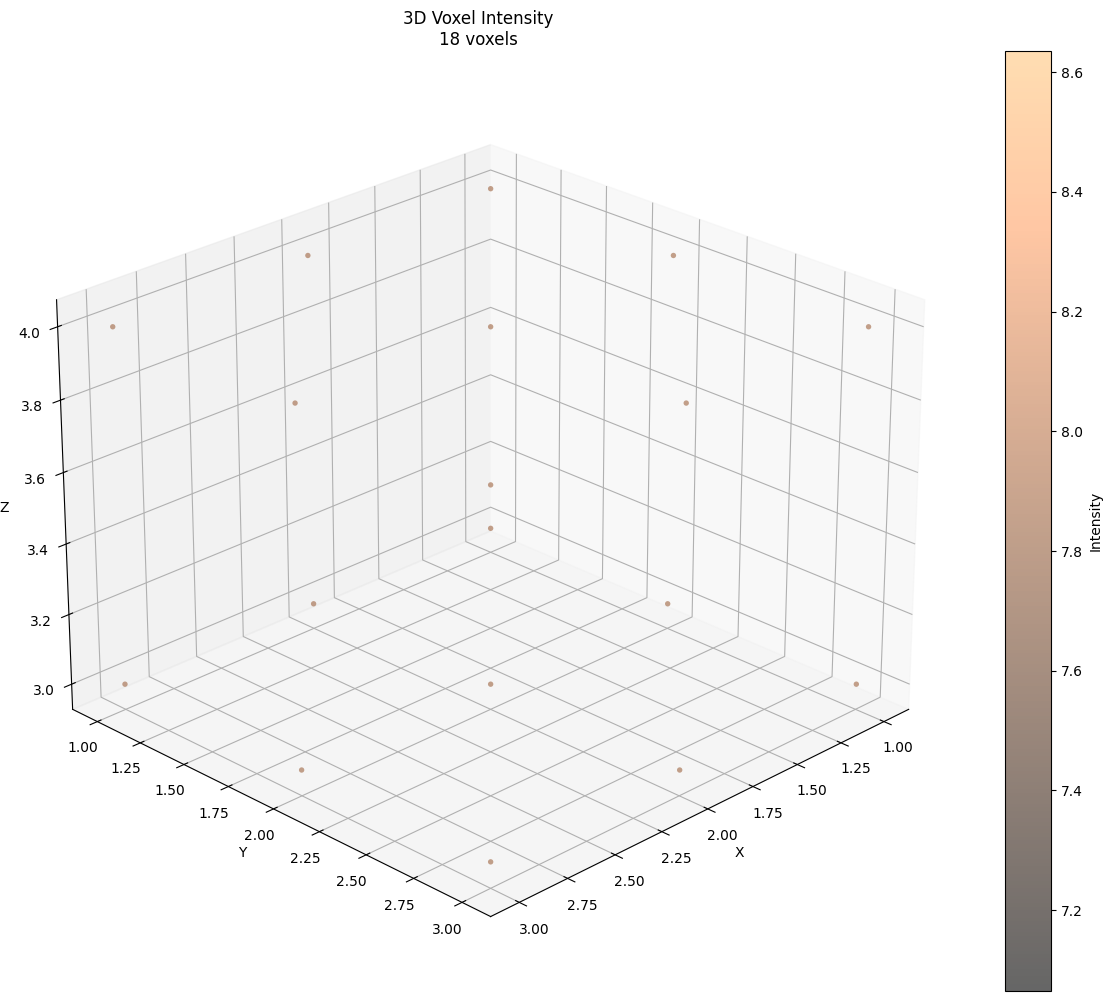

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load your voxel data
#voxels = np.load('voxels.npy')

# Set threshold
threshold = 2

# Get voxels above threshold
mask = voxels > threshold
x, y, z = np.where(mask)
values = voxels[mask]

print(f"Plotting {len(x):,} voxels")

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot colored dots
scatter = ax.scatter(x, y, z, 
                    c=values,  # Color by intensity
                    cmap='copper',  # 'viridis', 'plasma', 'inferno', 'magma' also good
                    s=15,  # Dot size
                    alpha=0.6,  # Transparency
                    linewidths=0)  # No border on dots

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Voxel Intensity\n{len(x):,} voxels')

# Add colorbar
plt.colorbar(scatter, ax=ax, label='Intensity')

# Set viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

Plotting 125 voxels


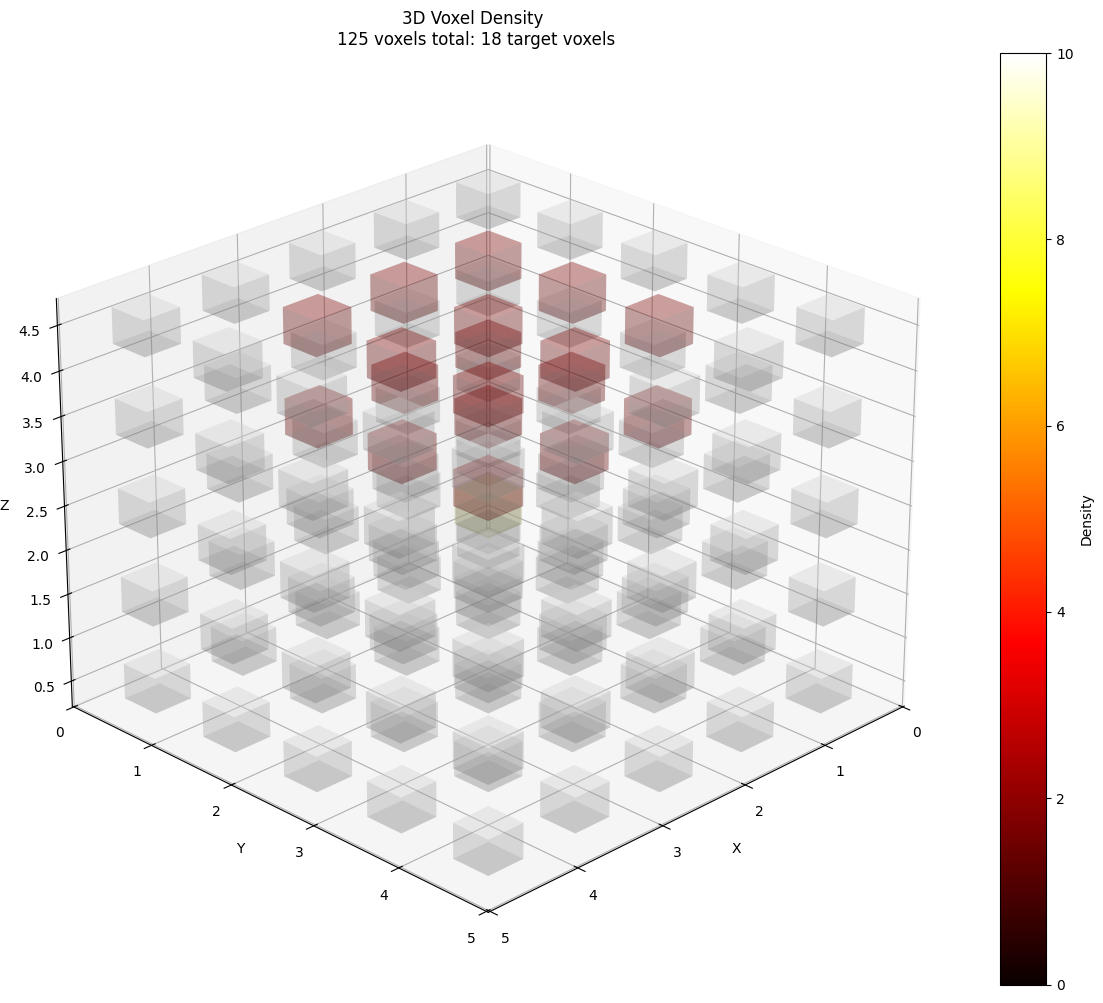

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

threshold = -0.1
mask = voxels > threshold

x, y, z = np.where(mask)
values = voxels[mask]

print(f"Plotting {len(x):,} voxels")

# --- Cube size (80%) ---
size = 0.4
offset = (1.0 - size) / 2.0

# --- Heatmap color range [0, 10] ---
norm = Normalize(vmin=0, vmax=10)
colors = cm.hot_r(norm(values))
colors[:, 3] = 0.2

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(
    x + offset,
    y + offset,
    z + offset,
    size,
    size,
    size,
    color=colors,
    shade=True,
    linewidth=0
)

threshold = 2
mask = voxels > threshold

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Voxel Density \n{len(x):,} voxels total: {len(mask[mask])} target voxels')

# Colorbar
mappable = cm.ScalarMappable(norm=norm, cmap='hot')
mappable.set_array([])
plt.colorbar(mappable, ax=ax, label='Density')

ax.view_init(elev=25, azim=45)
plt.tight_layout()
plt.show()


In [25]:
set(np.concatenate((np.concatenate(voxels))))

{np.float64(0.0), np.float64(1.0), np.float64(7.85)}

In [6]:
64**3

262144

In [3]:
import time
import tqdm
import tensorflow as tf
from utils import read_muons_data, read_voxels_data

In [7]:
import time
import tqdm
import tensorflow as tf
from utils import read_muons_data, read_voxels_data


#root = r"D:\muons_data\muons_40x40"


def serialize_example(x1, y1):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """

    # Create a dictionary mapping the feature name to the tf.train.Example-compatible data type.
    feature = {
        "x": tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(x1).numpy()])),
        "y": tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(y1).numpy()]))
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def tf_serialize_example(x, y):
    tf_string = tf.py_function(
        serialize_example,
        (x, y),
        tf.string
    )
    return tf.reshape(tf_string, ())


def data_generator():
    for i in tqdm.trange(100):
        x = read_muons_data(f"output_pandas_target.csv")
        y = read_voxels_data(f"square_flat_target_voxels.npy")

        yield serialize_example(x, y)


serialized_features_dataset = tf.data.Dataset.from_generator(
    data_generator, output_types=tf.string, output_shapes=()
)

filename = r"voxels_prediction_val.tfrecord"
writer = tf.data.experimental.TFRecordWriter(filename, compression_type="GZIP")
writer.write(serialized_features_dataset)


100%|█████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


In [2]:
dataset = tf.data.TFRecordDataset(filename)

In [5]:
def parse_tfrecord_generic(example_proto):
    """Try to parse without knowing exact structure"""
    # First, try to parse all possible types
    features = tf.io.parse_single_example(
        example_proto,
        features={
            # Try common feature names with multiple types
            'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
            'features': tf.io.VarLenFeature(tf.float32),
            'input_ids': tf.io.VarLenFeature(tf.int64),
            'height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
            'width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
            'text': tf.io.VarLenFeature(tf.string),
        }
    )
    return features

# Try parsing
parsed_dataset = dataset.map(parse_tfrecord_generic)

# Check what was actually parsed
for parsed in parsed_dataset.take(1):
    for key, value in parsed.items():
        print(f"{key}: {value.shape}, {value.dtype}")

2025-12-18 23:57:40.320145: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: DATA_LOSS: corrupted record at 0 (Is this even a TFRecord file?)


DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_7_device_/job:localhost/replica:0/task:0/device:CPU:0}} corrupted record at 0 (Is this even a TFRecord file?) [Op:IteratorGetNext] name: 